In [3]:
import pandas as pd 
from pathlib import Path
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Primary Table 

In [134]:
df = pd.read_csv("raw_data/raw_data.csv")
columns_to_convert = ['discovered_at', 'updated_at', 'transaction_timestamp', 'accepted_at','cooked_at','trashed_at','courier_arrived_at', 'cancelled_at']

for column in columns_to_convert:
    df[column] = pd.to_datetime(df[column], unit='ms')

conn = sqlite3.connect(':memory:')

df.to_sql('my_table', conn, index=False)

query = 'SELECT order_id,\
        facility_id,\
        facility_timezone,\
        facility_name,\
        created_at, \
        ordered_at as ordered_at, \
        confirmation_mode,\
        scheduling_type,\
        "delivery platform" as delivery_platform,\
        order_status,\
        prep_time_for_ofo_minutes,\
        subtotal,\
        usd_subtotal,\
        subtotal + CASE WHEN discount IS NULL THEN 0 ELSE discount END as revenue, \
        discount,\
        tax,\
        order_issue_count,\
        order_issue_types,\
        order_issue_details,\
        order_rating,\
        cancelled_at,\
        ofo_cancellation_reason \
        FROM \
        my_table'

df = pd.read_sql_query(query, conn)


conn.close()
df['created_at'] = pd.to_datetime(df['created_at'])





# Monthly Total by Facility




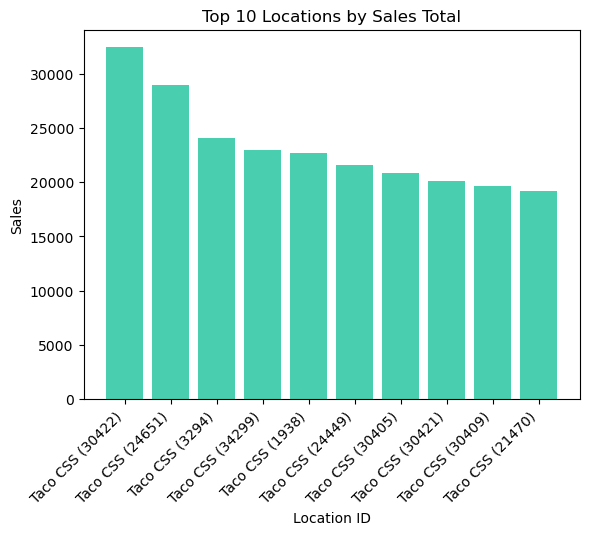

,facility_name,total_orders,subtotal,revenue,total_discounts,avg_prep_time,avg_revenue,total_issues,total_cancellations
0,Taco CSS (30422),1572,33838.29,32427.09,1135,13.775445,20.627920,73,0
1,Taco CSS (24651),1305,29934.91,28979.24,1064,14.608483,22.206314,127,0
2,Taco CSS (3294),1125,24701.26,24035.34,958,14.995483,21.364747,96,0
3,Taco CSS (34299),1166,23507.54,22968.52,1014,14.990876,19.698559,70,6
4,Taco CSS (1938),1197,23342.27,22647.15,1030,14.991575,18.919925,88,0


In [135]:

conn = sqlite3.connect(':memory:')

df.to_sql('my_table', conn, index=False)

query = 'SELECT \
        facility_name, \
        COUNT(order_id) as total_orders,\
        SUM(usd_subtotal) AS subtotal,\
        SUM(revenue) AS revenue,\
        SUM(CASE WHEN discount IS NOT NULL THEN 1 ELSE 0 END) as total_discounts, \
        AVG(prep_time_for_ofo_minutes) as avg_prep_time, \
        AVG(revenue) as avg_revenue, \
        COUNT(order_issue_count) as total_issues,\
        COUNT(ofo_cancellation_reason) as total_cancellations  \
         \
        FROM my_table \
        WHERE order_status != "OFO_STATUS_CANCELED" \
        \
        GROUP BY 1 \
        ORDER BY SUM(revenue) DESC '

result_df = pd.read_sql_query(query, conn).sort_values(by="revenue",ascending=False)
csv_export = result_df[:10]
csv_export.to_csv("clean_data/top_ten.csv")
result_df.to_csv("clean_data/monthly.csv")


conn.close()
categories = result_df["facility_name"][:10]
values = result_df["revenue"][:10]

plt.bar(categories, values,color="#49CFAF")

plt.xlabel('Location ID')
plt.ylabel('Sales')
plt.title('Top 10 Locations by Sales Total')

plt.xticks(rotation=45, ha='right')

plt.show()
print()
result_df.head()

# Daily Totals




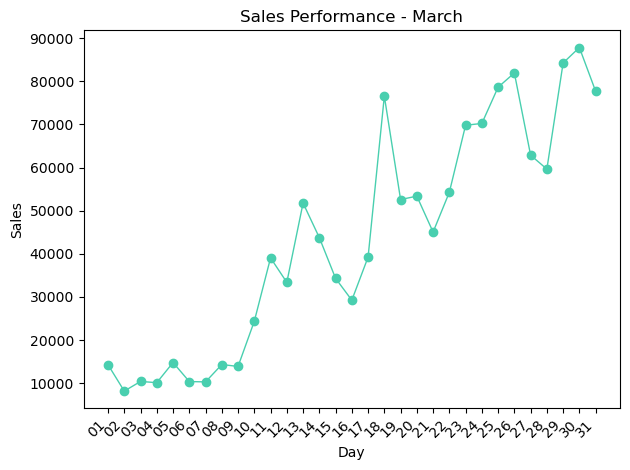

Mean Daily Percent Diff: 10.447097952192944
Mean Daily Issues: 89.0
Mean Daily Orders: 2055.8709677419356
Mean Daily Rev: 43765.17645161293
Mean Daily Discounts: 1566.4516129032259


,created_at,total_orders,subtotal,revenue,total_discounts,avg_prep_time,avg_revenue,total_issues,total_cancellations,percent_diff_rev
0,01,635,14355.30,14271.73,561,14.677165,22.475165,41,0,NaN
1,02,416,8334.29,8164.52,374,14.699519,19.626250,17,0,-42.792359
2,03,487,10526.38,10401.01,426,14.620123,21.357310,26,0,27.392792
3,04,452,10264.44,10118.82,411,14.712389,22.386770,24,0,-2.713102
4,05,629,14926.03,14791.81,561,14.650238,23.516391,30,0,46.181175


In [136]:

conn = sqlite3.connect(':memory:')

df.to_sql('my_table', conn, index=False)

query = 'SELECT \
        strftime("%d", created_at) as created_at,\
        COUNT(order_id) as total_orders,\
        SUM(usd_subtotal) AS subtotal,\
        SUM(revenue) AS revenue,\
        SUM(CASE WHEN discount IS NOT NULL THEN 1 ELSE 0 END) as total_discounts, \
        AVG(prep_time_for_ofo_minutes) as avg_prep_time, \
        AVG(revenue) as avg_revenue, \
        COUNT(order_issue_count) as total_issues,\
        COUNT(ofo_cancellation_reason) as total_cancellations  \
        FROM my_table \
        WHERE order_status != "OFO_STATUS_CANCELED" \
        GROUP BY 1\
        ORDER BY 1 ASC'

result_df = pd.read_sql_query(query, conn)

conn.close()
result_df["percent_diff_rev"] = ((result_df["revenue"] - result_df["revenue"].shift())/ result_df["revenue"].shift()) * 100

result_df.to_csv("clean_data/daily.csv")

categories = result_df["created_at"]
values = result_df["revenue"]

plt.plot(categories, values, marker='o', color='#49CFAF', linestyle='-', linewidth=1)

plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales Performance - March')

plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()

print(f"Mean Daily Percent Diff: {result_df['percent_diff_rev'].mean()}")
print(f"Mean Daily Issues: {result_df['total_issues'].mean()}")
print(f"Mean Daily Orders: {result_df['total_orders'].mean()}")
print(f"Mean Daily Rev: {result_df['revenue'].mean()}")
print(f"Mean Daily Discounts: {result_df['total_discounts'].mean()}")



result_df.head()



# March Totals

In [137]:

conn = sqlite3.connect(':memory:')

df.to_sql('my_table', conn, index=False)

query = 'SELECT \
        COUNT(order_id) as total_orders,\
        SUM(usd_subtotal) AS subtotal,\
        SUM(revenue) AS revenue,\
        SUM(CASE WHEN discount IS NOT NULL THEN 1 ELSE 0 END) as total_discounts, \
        AVG(prep_time_for_ofo_minutes) as avg_prep_time, \
        AVG(revenue) as avg_revenue, \
        SUM(CASE WHEN discount IS NOT NULL THEN 1 ELSE 0 END) as total_discounts, \
        AVG(CASE WHEN discount = "0" THEN NULL ELSE discount END)as avg_discount, \
        MIN(discount) as min_discount, \
        COUNT(order_issue_count) as total_issues,\
        COUNT(ofo_cancellation_reason) as total_cancellations  \
        FROM my_table \
        WHERE order_status != "OFO_STATUS_CANCELED" \
        '

result_df = pd.read_sql_query(query, conn)


conn.close()
result_df.to_csv("clean_data/total_month.csv")
result_df.head()

,total_orders,subtotal,revenue,total_discounts,avg_prep_time,avg_revenue,total_discounts,avg_discount,min_discount,total_issues,total_cancellations
0,63732,1393351.39,1356720.47,48560,14.696135,21.2879,48560,-5.317306,-20.46,2759,11


# Delivery Partner

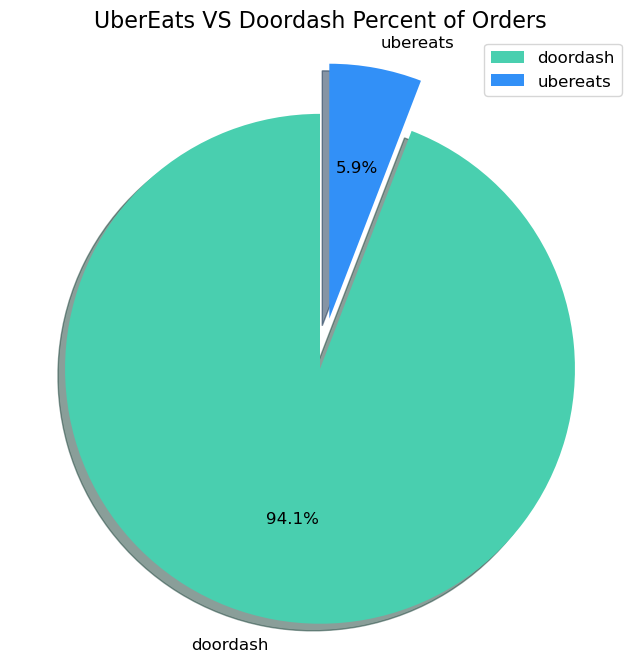

,delivery_platform,total_orders,revenue
0,doordash,60003,1275669.37
1,ubereats,3729,81051.10


In [138]:

conn = sqlite3.connect(':memory:')

df.to_sql('my_table', conn, index=False)


query = 'SELECT  \
        delivery_platform,\
        COUNT(order_id) as total_orders,\
        SUM(revenue) as revenue\
        FROM my_table \
        WHERE order_status != "OFO_STATUS_CANCELED"\
        GROUP BY 1 \
        '

result_df = pd.read_sql_query(query, conn)
result_df.to_csv("clean_data/query4.csv")
conn.close()


labels = result_df["delivery_platform"]
sizes = result_df["total_orders"]

custom_colors = ['#49CFAF', '#3290F7']

explode = (0.1, 0.1)  

plt.figure(figsize=(8, 8))  
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=custom_colors, explode=explode,
        shadow=True, textprops={'fontsize': 12})  
plt.title('UberEats VS Doordash Percent of Orders', fontsize=16)  

plt.axis('equal')

plt.legend(loc='upper right', fontsize=12)

plt.show()
result_df.head()



# Cancels by Location





In [131]:
## Removed cancel ordered filter in previous
conn = sqlite3.connect(':memory:')

df.to_sql('my_table', conn, index=False)

query = 'SELECT \
        facility_name, \
        COUNT(order_id) as total_orders,\
        SUM(revenue) AS revenue,\
        SUM(CASE WHEN order_status = "OFO_STATUS_CANCELED" THEN 1 ELSE 0 END) as total_cancellations,  \
        SUM(CASE WHEN order_status = "OFO_STATUS_CANCELED" THEN revenue ELSE 0 END) as lost_rev  \
        FROM my_table \
        GROUP BY 1\
        ORDER BY 1 ASC'

result_df = pd.read_sql_query(query, conn)

conn.close()
result_df["percent_cancel"] = result_df["total_cancellations"]/result_df["total_orders"]

result_df.sort_values(by="total_cancellations",ascending=False,inplace=True)

result_df.to_csv("clean_data/cancels.csv")

result_df.head(10)



,facility_name,total_orders,revenue,total_cancellations,lost_rev,percent_cancel
40,Taco CSS (24449),1173,24344.24,126,2801.63,0.107417
97,Taco CSS (30409),967,23158.89,122,3467.76,0.126163
136,Taco CSS (34299),1278,25078.30,112,2109.78,0.087637
15,Taco CSS (1880),1018,18964.30,99,1896.00,0.097250
43,Taco CSS (24651),1402,31286.65,97,2307.41,0.069187
142,Taco CSS (4014),749,16189.12,70,1790.01,0.093458
81,Taco CSS (27902),711,13856.79,67,1438.89,0.094233
133,Taco CSS (3294),1185,25274.28,60,1238.94,0.050633
48,Taco CSS (26084),656,14275.03,60,1533.44,0.091463
28,Taco CSS (2260),761,16206.35,58,1291.83,0.076216


In [139]:
# percentile_50 = result_df['march_subtotal'].quantile(0.50)  # 50th percentile (median)
# percentile_25 = result_df['march_subtotal'].quantile(0.25)  # 50th percentile (median)
# percentile_75 = result_df['march_subtotal'].quantile(0.75)  # 50th percentile (median)

# print(percentile_25)
# print(percentile_50)

# print(percentile_75)


# All Cancels March


In [133]:

conn = sqlite3.connect(':memory:')

df.to_sql('my_table', conn, index=False)

query = 'SELECT \
        COUNT(order_id) as total_orders,\
        SUM(revenue) AS revenue,\
        SUM(CASE WHEN order_status = "OFO_STATUS_CANCELED" THEN 1 ELSE 0 END) as total_cancellations,  \
        SUM(CASE WHEN order_status = "OFO_STATUS_CANCELED" THEN revenue ELSE 0 END) as lost_rev  \
        FROM my_table \
        '

result_df = pd.read_sql_query(query, conn)

conn.close()
result_df["percent_cancel"] = result_df["total_cancellations"]/result_df["total_orders"]

result_df.sort_values(by="total_cancellations",ascending=False,inplace=True)

result_df.to_csv("clean_data/cancels_month.csv")

result_df.head(10)



,total_orders,revenue,total_cancellations,lost_rev,percent_cancel
0,66344,1413628.21,2612,56907.74,0.039371


# Merp :o 


In [ ]:

conn = sqlite3.connect(':memory:')

df.to_sql('my_table', conn, index=False)

query = 'SELECT \
        facility_name, \
        COUNT(order_id) as total_orders,\
        FROM my_table \
        GROUP BY 1\
        ORDER BY 1 ASC'

result_df = pd.read_sql_query(query, conn)

conn.close()
result_df["percent_cancel"] = result_df["total_cancellations"]/result_df["total_orders"]

result_df.sort_values(by="total_cancellations",ascending=False,inplace=True)

result_df.to_csv("clean_data/cancels.csv")

result_df.head(10)

